In [1]:
# imports
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import time
import copy

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchvision import transforms, utils
from torchsummary import summary

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

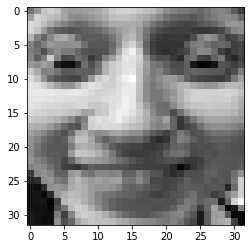

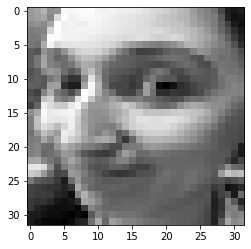

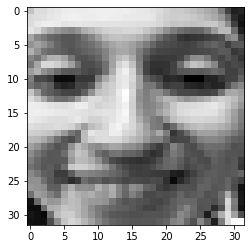

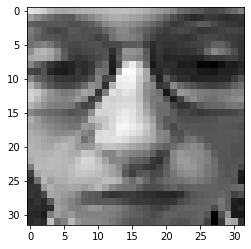

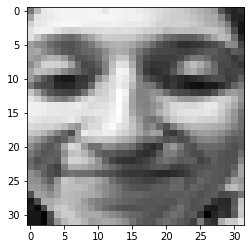

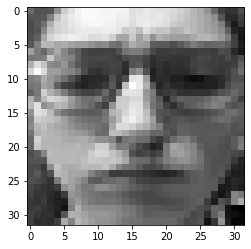

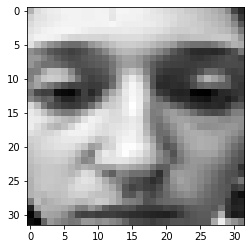

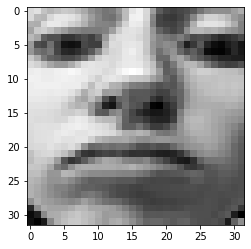

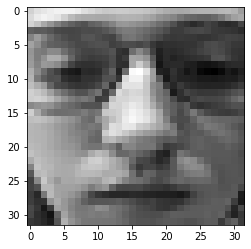

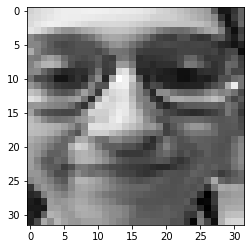

In [2]:
# convert to gray-scale images, resize them into the same resolution as the CMU PIE

# 10 personal seflie photos stored in folder "0_raw" and named from '1.jpg' to '10.jpg'

if not os.path.exists(os.path.join('PIE', '0')):  # create folder subject "0" (this is me) for processed selfies 
    os.mkdir(os.path.join('PIE', '0'))

for img_path in sorted([f for f in os.listdir(os.path.join('PIE', '0_raw')) if f.endswith('.jpg')]):
    img = Image.open(os.path.join('PIE', '0_raw', img_path)).convert('L')
    width, height = img.size 
    img = img.crop((width//8, height//8, 7*width//8, 7*height//8)).resize((32,32), PIL.Image.LANCZOS) 
    # resize raw selfies to get 32x32 images
    plt.imshow(img, cmap='gray')
    plt.show()
    if not os.path.exists(os.path.join('PIE', '0', img_path)): # save cropped image if not already done
        img.save(os.path.join('PIE', '0', img_path))

In [3]:
# load dataset

# choose
random.seed(42)
subjects = np.sort([0] + random.sample(range(1, 69), 25)) # subjects = me + 25 ramdomly picked subjects
print('26 subject numbers: {}'.format(subjects))

n_imgs_subj = [len([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]) for s in subjects]
# get number of images per suject in each folder of the 26 subjects
n_imgs = sum(n_imgs_subj) # total number of images for the study
print('number of images per subject: {}'.format(n_imgs_subj))
print('total number of images : {}'.format(n_imgs))

# create X (dataset images) and y (corresponding label)
X = np.empty((n_imgs, 32, 32))
y = np.empty((n_imgs, 1))

for si, s in enumerate(subjects):
    for i, img_path in enumerate([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]):
        img_path = os.path.join('PIE', str(s), str(i+1)+'.jpg')
        X[sum(n_imgs_subj[:si]) + i, :, :] = np.array(Image.open(img_path))
        y[sum(n_imgs_subj[:si]) + i] = s

print('X or dataset shape: {}\ny or label shape: {}'.format(X.shape, y.shape))

# split train and test (ratio 70-30%) and separate CMUPIE dataset from selfies
X_train_CMUPIE, X_test_CMUPIE, y_train_CMUPIE, y_test_CMUPIE = train_test_split(
    X[(y.flatten() != 0), :, :], y[y != 0], test_size=0.3, random_state=42)
X_train_selfies, X_test_selfies, y_train_selfies, y_test_selfies = train_test_split(
    X[(y.flatten() == 0), :, :], y[y == 0], test_size=0.3, random_state=42)
X_train = np.concatenate([X_train_CMUPIE, X_train_selfies], axis=0)
y_train = np.concatenate([y_train_CMUPIE, y_train_selfies], axis=0)
X_test = np.concatenate([X_test_CMUPIE, X_test_selfies], axis=0)
y_test = np.concatenate([y_test_CMUPIE, y_test_selfies], axis=0)
print('#images in train set: {}\n#images in test set: {}'.format(y_train.shape[0], y_test.shape[0]))

26 subject numbers: [ 0  2  3  4  6  7  9 13 14 15 28 29 32 33 35 36 38 39 44 48 52 56 58 62
 66 68]
number of images per subject: [10, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 164, 170, 170, 170, 170, 170, 170, 170, 170, 170]
total number of images : 4254
X or dataset shape: (4254, 32, 32)
y or label shape: (4254, 1)
#images in train set: 2977
#images in test set: 1277


# Q1: PCA

## 1) Visualisation

In [4]:
random.seed(42)
# randomly pick 500 images from train set
images_ids = np.sort(random.sample(range(X_train.shape[0]), 500))
X_small = X_train[images_ids,:,:]
y_small = y[images_ids]
# normalise
scaler = StandardScaler()
X_small_norm = scaler.fit_transform(X_small.reshape(500, -1))

In [5]:
# apply PCA and keep 3 first components
pca_3 = PCA(n_components=3)
X_PCA_3 = pca_3.fit_transform(X_small_norm)
X_PCA_3.shape

(500, 3)

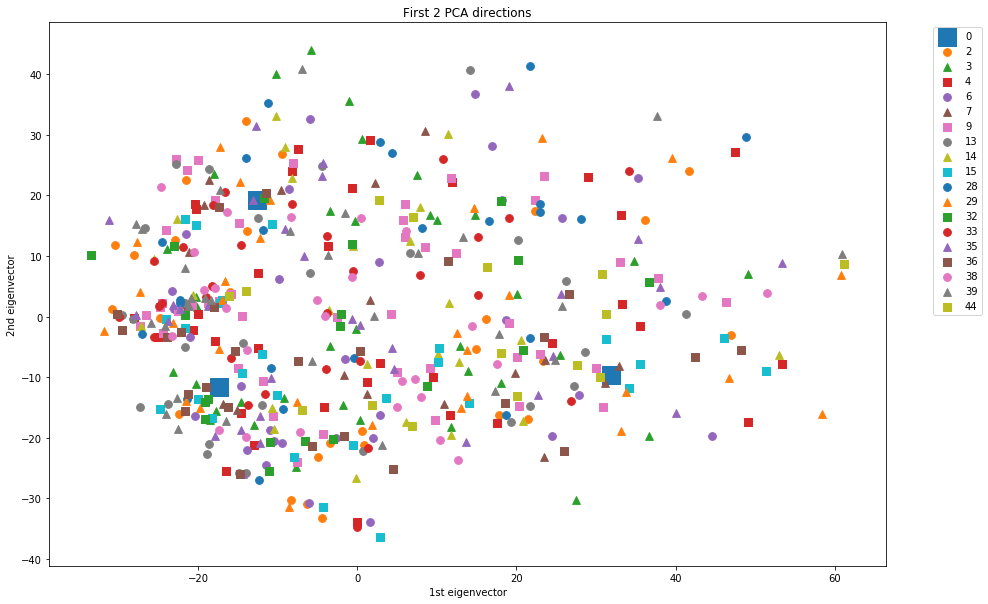

In [6]:
# plot 2d PCA projection
plt.figure(figsize=(15,10))
style = y_small.flatten()[:]
markers = ["s","o", "^"]

for i, c in enumerate(np.unique(y_small)):
    s = 60 if i != 0 else 300
    plt.scatter(X_PCA_3[:, 0][y_small.flatten()==c], X_PCA_3[:, 1][y_small.flatten()==c],
                marker=markers[i%3], s=s, label=int(c))
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')
plt.title("First 2 PCA directions")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

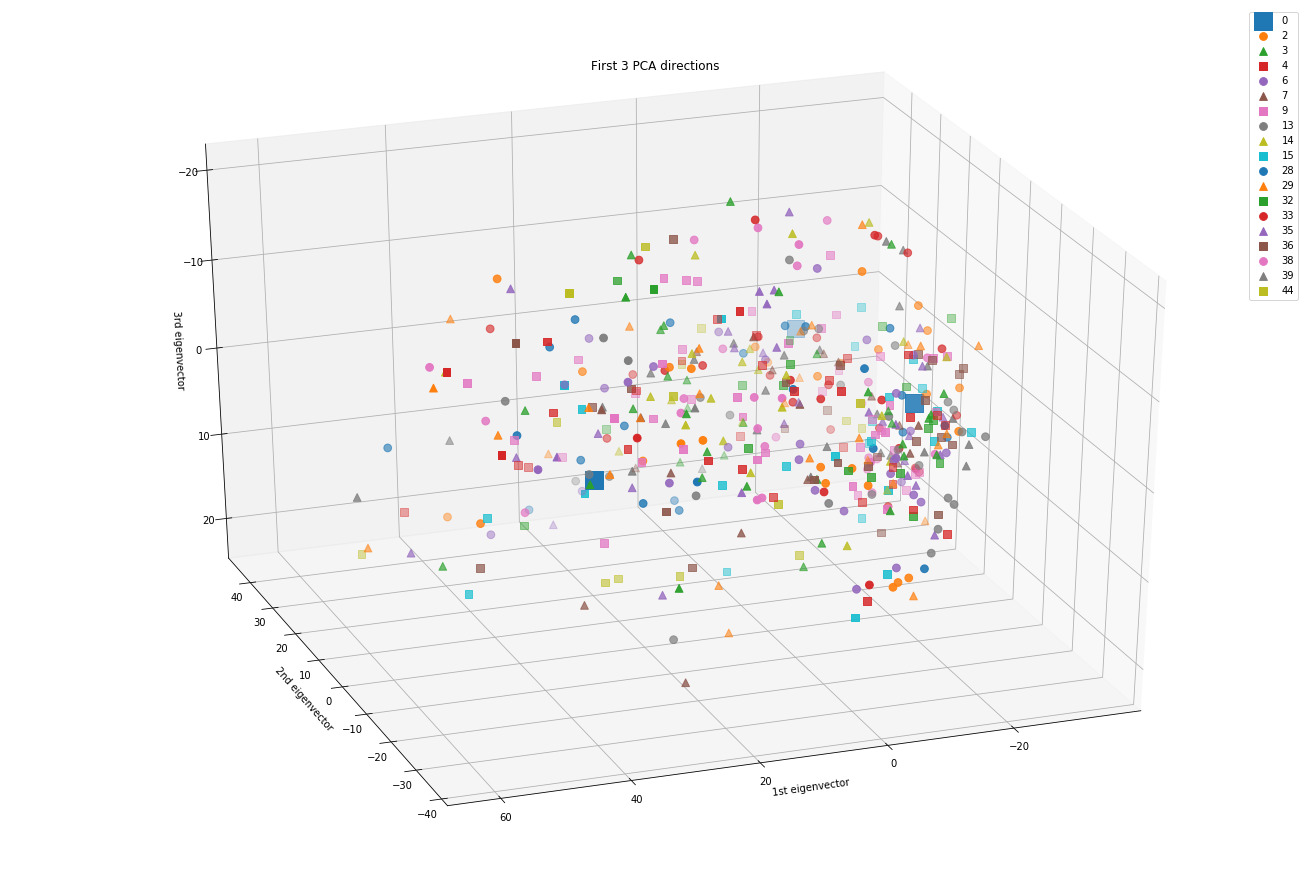

In [7]:
# plot 3d pca projection
fig = plt.figure(1, figsize=(18, 12))
ax = Axes3D(fig, elev=-150, azim=110)
for i, c in enumerate(np.unique(y_small)):
    s = 60 if i != 0 else 300
    xs = X_PCA_3[list((y_small.flatten() == c)),:]
    ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], marker=markers[i%3], s=s, label = int(c))
ax.set_title("First 3 PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")
ax.legend()

In [43]:
# PCA explained variance ratio
for i in range(3):
    print('PC {}: explained variance = {:.2f} %'.format(i, 100* pca_3.explained_variance_ratio_[i]))

PC 0: explained variance = 43.03 %
PC 1: explained variance = 25.61 %
PC 2: explained variance = 5.92 %


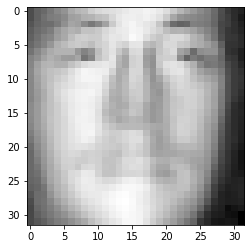

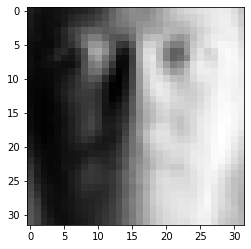

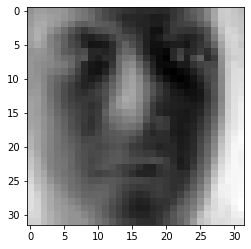

In [9]:
# visualize the corresponding 3 eigenfaces used for the dimensionality reduction
eigenfaces_3 = pca_3.components_.reshape((-1, 32, 32))
for eigen in eigenfaces_3:
    plt.imshow(eigen, cmap='gray')
    plt.show()

## 2) Classification using a K-Nearest Neighboor (KNN) model

In [10]:
# normalise training set
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
# apply normalisation to testing sets
X_test_norm = scaler.transform(X_test.reshape(X_test.shape[0], -1))
X_test_norm_CMUPIE = scaler.transform(X_test_CMUPIE.reshape(X_test_CMUPIE.shape[0], -1))
X_test_norm_selfies = scaler.transform(X_test_selfies.reshape(X_test_selfies.shape[0], -1))
print(X_test_norm_CMUPIE.shape, X_test_norm_selfies.shape)
print(X_small_norm.shape, y_small.shape)
print(X_train_norm.shape, y_train.shape)
X_train_vec = X_train.reshape(X_train.shape[0], -1)
X_test_vec = X_test.reshape(X_test.shape[0], -1)

(1274, 1024) (3, 1024)
(500, 1024) (500, 1)
(2977, 1024) (2977,)


In [11]:
# reduced datasets
reduced_datasets_PCA = {}
for ncomp in [40, 80, 200]:
    pca_ncomp = PCA(n_components=ncomp)
    reduced_datasets_PCA[ncomp] = [pca_ncomp.fit_transform(X_train_norm), # X_train
                              pca_ncomp.transform(X_test_norm_CMUPIE), # X_test_CMUPIE
                              pca_ncomp.transform(X_test_norm_selfies), # X_test_selfies
                              pca_ncomp.transform(X_test_norm)] # X_test

In [12]:
# nearest neighboors
#  classification accuracy on the CMU PIE test images and own your own photo separately
for ncomp, item in reduced_datasets_PCA.items():
    print(ncomp)
    x_train, x_test_CMUPIE, x_test_selfies, x_test = item
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(x_train, y_train.flatten())
    y_pred_CMUPIE = clf.predict(x_test_CMUPIE)
    y_pred_selfies = clf.predict(x_test_selfies)
    y_pred = clf.predict(x_test)
    print("accuracy on {} dimension for CMUPIE: {}".format(ncomp, accuracy_score(y_test_CMUPIE.flatten(), y_pred_CMUPIE)))
    print("accuracy on {} dimension for selfies: {}".format(ncomp, accuracy_score(y_test_selfies.flatten(), y_pred_selfies)))
    print("accuracy on {} dimension for test: {}".format(ncomp, accuracy_score(y_test.flatten(), y_pred)))

40
accuracy on 40 dimension for CMUPIE: 0.8430141287284144
accuracy on 40 dimension for selfies: 1.0
accuracy on 40 dimension for test: 0.8433829287392326
80
accuracy on 80 dimension for CMUPIE: 0.869701726844584
accuracy on 80 dimension for selfies: 1.0
accuracy on 80 dimension for test: 0.870007830853563
200
accuracy on 200 dimension for CMUPIE: 0.8869701726844584
accuracy on 200 dimension for selfies: 0.6666666666666666
accuracy on 200 dimension for test: 0.8864526233359437


# Q2: LDA for feature extraction and classification

In [14]:
# reduced datasets and LDA applied
lda_2 = LinearDiscriminantAnalysis(n_components=2)
X_train_LDA_2 = lda_2.fit_transform(X_small_norm, y_small.flatten())
lda_3 = LinearDiscriminantAnalysis(n_components=3)
X_train_LDA_3 = lda_3.fit_transform(X_small_norm, y_small.flatten())
lda_9 = LinearDiscriminantAnalysis(n_components=9)
X_train_LDA_9 = lda_9.fit_transform(X_small_norm, y_small.flatten())

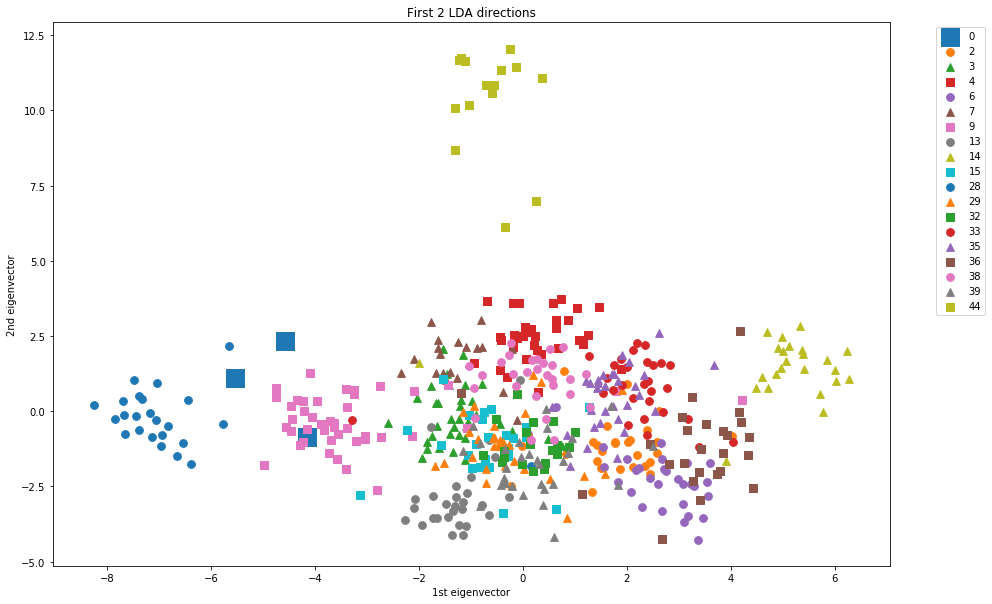

In [15]:
# plot 2D LDA projection
plt.figure(figsize=(15,10))
style = y_small.flatten()[:]
markers = ["s","o", "^"]

for i, c in enumerate(np.unique(y_small)):
    s = 60 if i != 0 else 300
    plt.scatter(X_train_LDA_3[:, 0][y_small.flatten()==c], X_train_LDA_3[:, 1][y_small.flatten()==c],
                marker=markers[i%3], s=s, label=int(c))
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')
plt.title("First 2 LDA directions")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

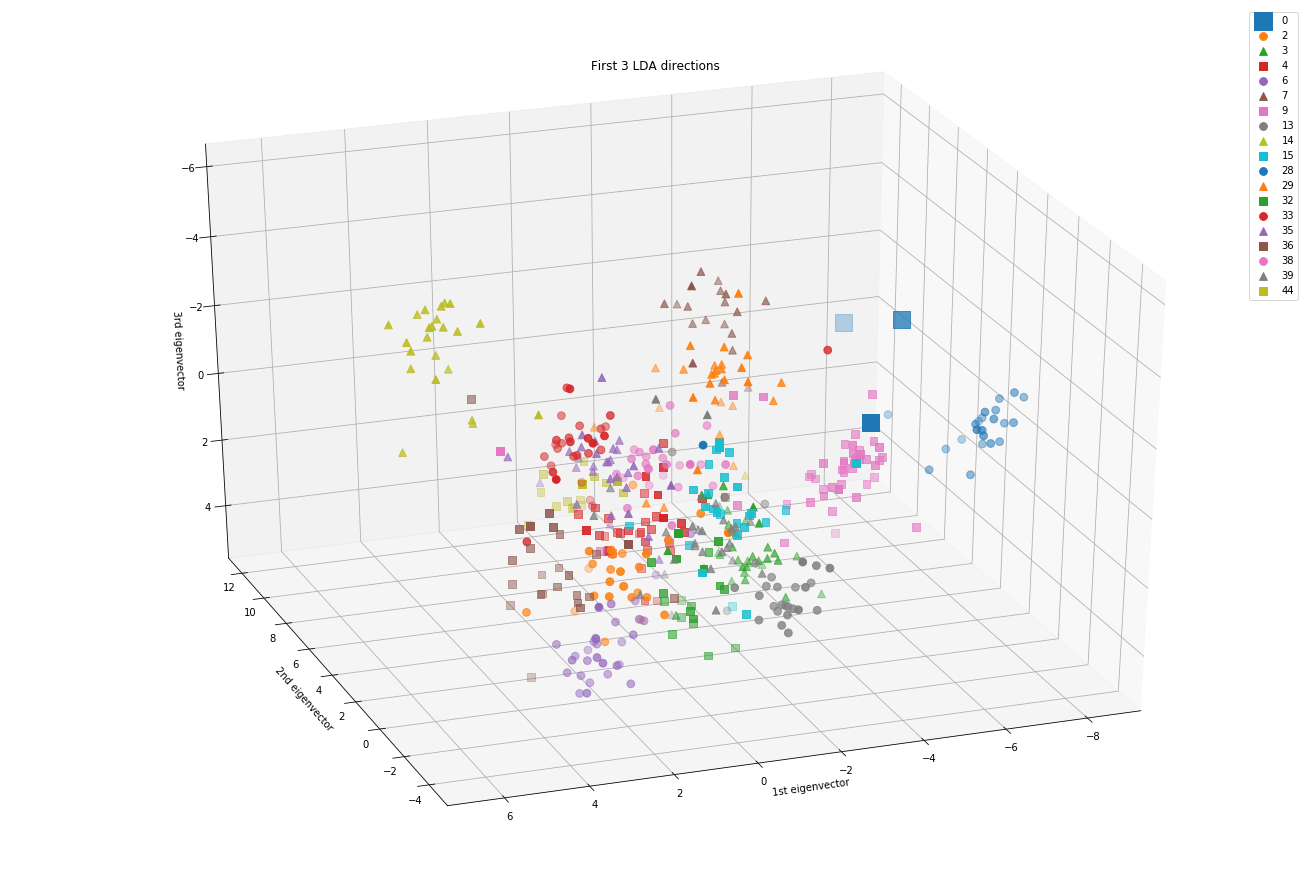

In [16]:
# apply LDA 3d projection
fig = plt.figure(1, figsize=(18, 12))
ax = Axes3D(fig, elev=-150, azim=110)
for i, c in enumerate(np.unique(y_small)):
    s = 60 if i != 0 else 300
    xs = X_train_LDA_3[list((y_small.flatten() == c)),:]
    ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], marker=markers[i%3], s=s, label = int(c))
ax.set_title("First 3 LDA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")
ax.legend()

In [17]:
# reduced datasets and LDA transformation
reduced_datasets_LDA = {}
for ncomp in [2, 3, 9]:
    lda_ncomp = LinearDiscriminantAnalysis(n_components=ncomp)
    reduced_datasets_LDA[ncomp] = [lda_ncomp.fit_transform(X_train_norm, y_train), # X_train
                              lda_ncomp.transform(X_test_norm_CMUPIE), # X_test_CMUPIE
                              lda_ncomp.transform(X_test_norm_selfies), # X_test_selfies
                              lda_ncomp.transform(X_test_norm)] # X_test

In [18]:
# nearest neighboors
#  classification accuracy on the CMU PIE test images and own your own photo separately
for ncomp, item in reduced_datasets_LDA.items():
    print(ncomp)
    x_train, x_test_CMUPIE, x_test_selfies, x_test = item
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(x_train, y_train.flatten())
    y_pred_CMUPIE = clf.predict(x_test_CMUPIE)
    y_pred_selfies = clf.predict(x_test_selfies)
    y_pred = clf.predict(x_test)
    print("accuracy on {} dimension for CMUPIE: {}".format(ncomp, accuracy_score(y_test_CMUPIE.flatten(), y_pred_CMUPIE)))
    print("accuracy on {} dimension for selfies: {}".format(ncomp, accuracy_score(y_test_selfies.flatten(), y_pred_selfies)))
    print("accuracy on {} dimension for test: {}".format(ncomp, accuracy_score(y_test.flatten(), y_pred)))

2
accuracy on 2 dimension for CMUPIE: 0.46703296703296704
accuracy on 2 dimension for selfies: 0.6666666666666666
accuracy on 2 dimension for test: 0.46750195771339076
3
accuracy on 3 dimension for CMUPIE: 0.6452119309262166
accuracy on 3 dimension for selfies: 1.0
accuracy on 3 dimension for test: 0.6460454189506656
9
accuracy on 9 dimension for CMUPIE: 0.9317111459968603
accuracy on 9 dimension for selfies: 0.3333333333333333
accuracy on 9 dimension for test: 0.9303054032889585


# Q3: GMM for clustering

In [20]:
# reducted dataset preprocessed
reduced_datasets = {}
reduced_datasets["raw"] = [X_train_vec, X_test_vec]
for ncomp in [80, 200]:
    pca_ncomp = PCA(n_components=ncomp)
    reduced_datasets[ncomp] = [pca_ncomp.fit_transform(X_train_norm), # X_train
                              pca_ncomp.transform(X_test_norm)] # X_test

raw


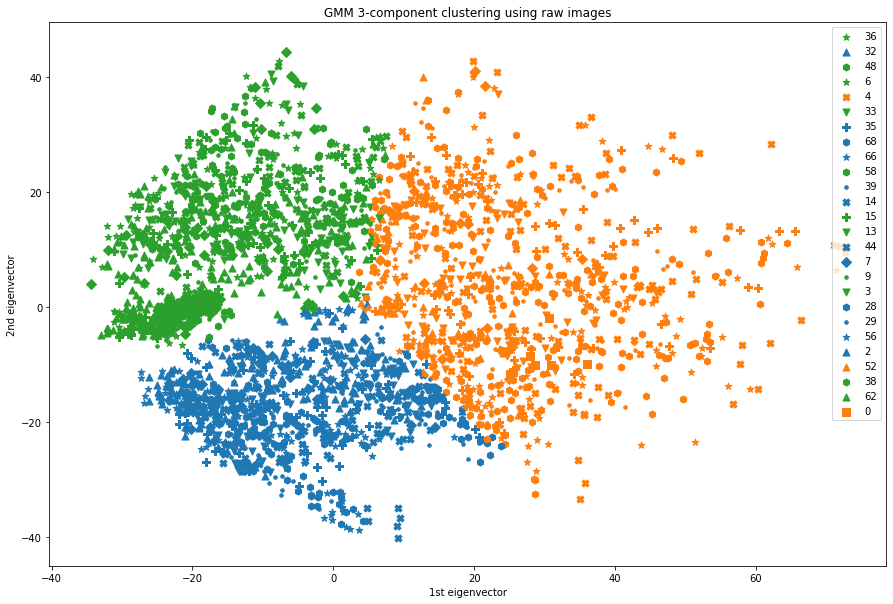

[36.0, 48.0, 35.0, 66.0, 3.0]


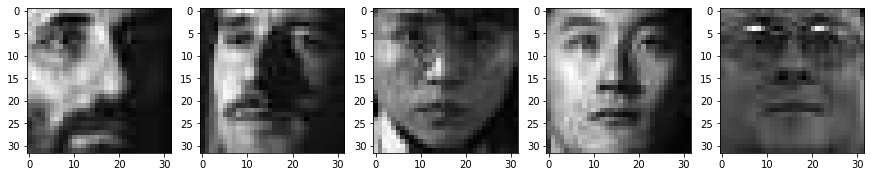

[33.0, 58.0, 15.0, 44.0, 7.0]


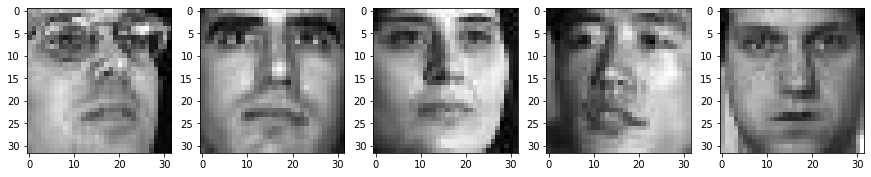

[32.0, 6.0, 4.0, 68.0, 39.0]


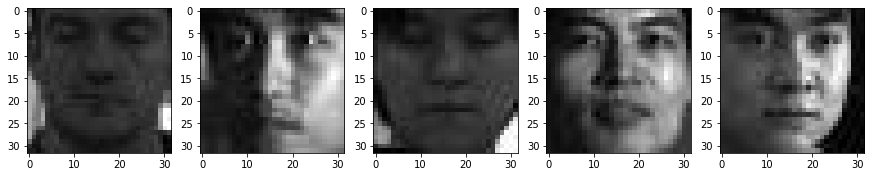

80


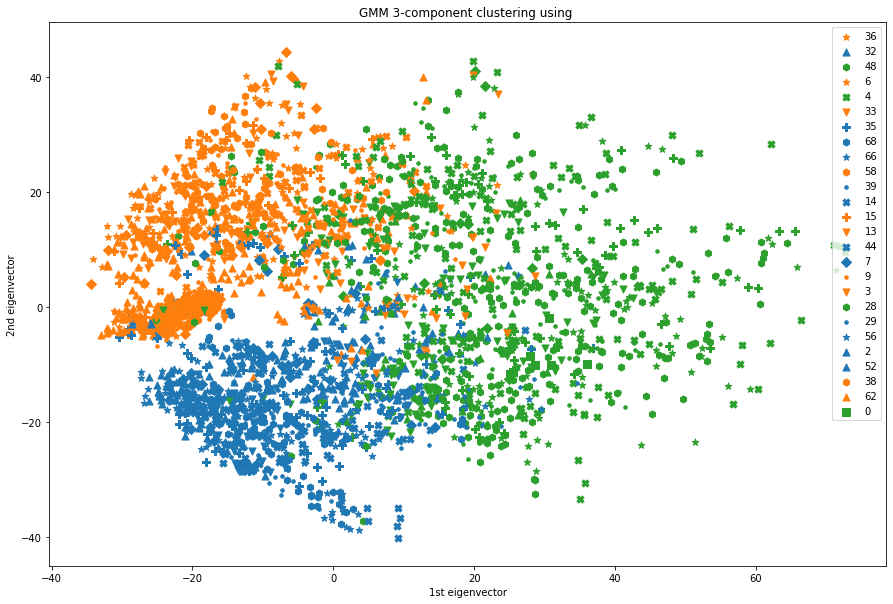

[36.0, 48.0, 35.0, 66.0, 3.0]


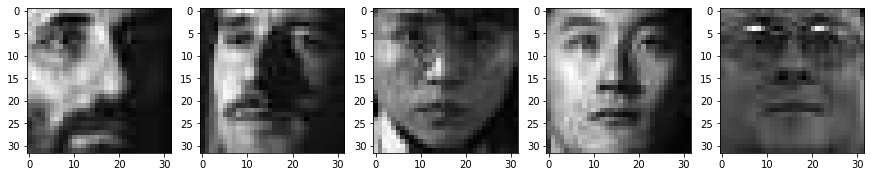

[32.0, 6.0, 4.0, 68.0, 39.0]


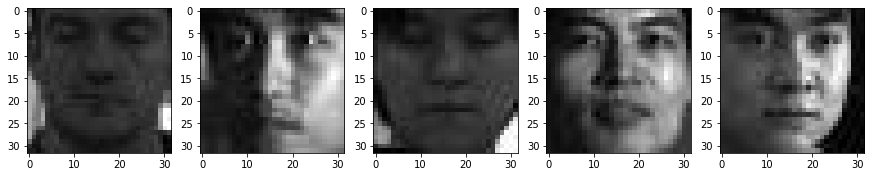

[33.0, 58.0, 15.0, 7.0, 39.0]


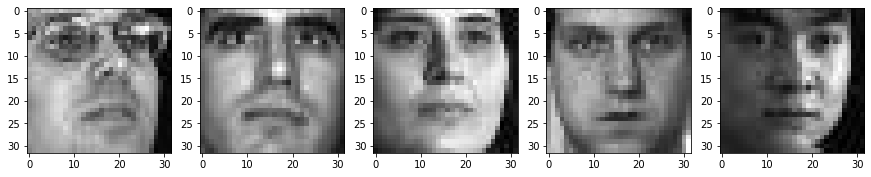

200


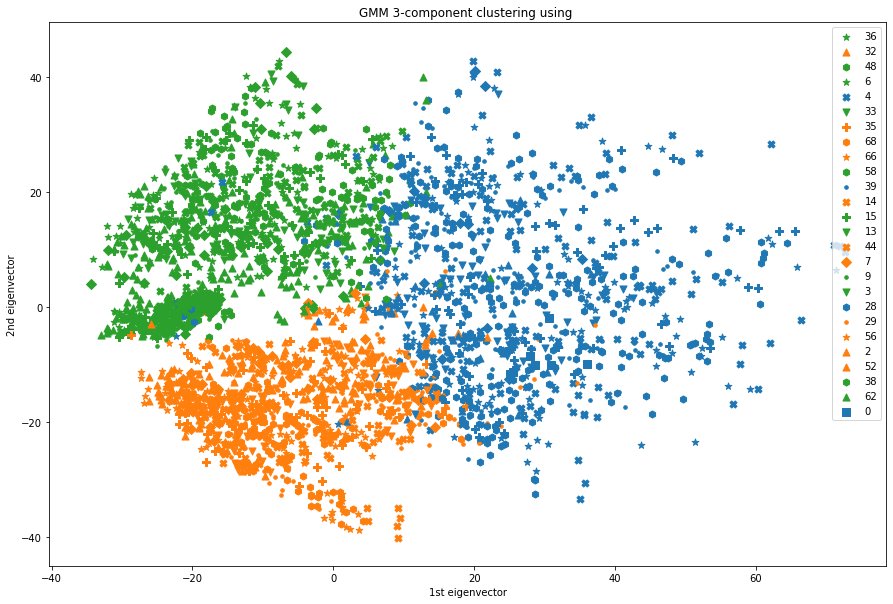

[33.0, 58.0, 15.0, 44.0, 7.0]


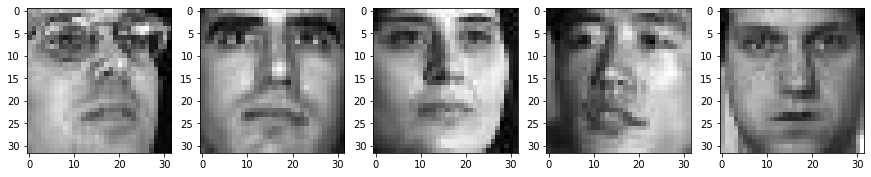

[36.0, 48.0, 35.0, 66.0, 3.0]


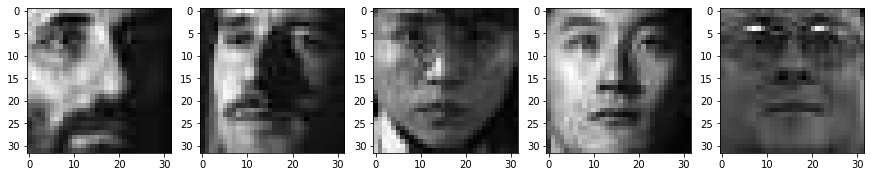

[32.0, 6.0, 4.0, 68.0, 39.0]


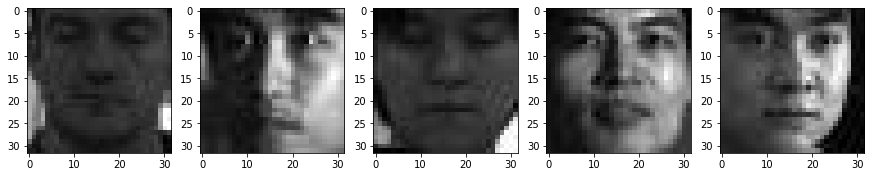

In [21]:
# PCA features extraction
for ncomp, item in reduced_datasets.items():
    print(ncomp)
    x_train, x_test = item
    clf = GaussianMixture(n_components=3)
    y_preds = clf.fit_predict(x_train)
    if ncomp == 'raw':
        x_train, x_test = reduced_datasets[80]
    markers = ["s","o", "^", 'v', 'X', 'P', '*', 'D', 'h', '.',
              '1', '2', '3', '4', '8', 'x', 'd', 'p', 'H', '_',
               '|', '<', '>']
    colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}
    
    plt.figure(figsize=(15,10))
    for i in range(x_train.shape[0]):
        plt.scatter(x_train[i, 0], x_train[i, 1], c=colors[y_preds[i]],
                    marker=markers[int(y_train[i])%10], s=50, label=int(y_train[i]))
    plt.xlabel('1st eigenvector')
    plt.ylabel('2nd eigenvector')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    if ncomp == 'raw':
        plt.title("GMM 3-component clustering using raw images")
    else:
        plt.title("GMM 3-component clustering using ".format(ncomp))
    plt.show()
    
    for gmcomp in [0, 1, 2]:
        ygmcomp = Counter(y_train[np.where(y_preds == gmcomp)[0]])
        ygmcomp_main = list(ygmcomp.keys())[:5]
        print(ygmcomp_main)
        f, axarr = plt.subplots(1,5, figsize=(15,6))
        axarr[0].imshow(X_train[y_train == int(ygmcomp_main[0])][0], cmap='gray')
        axarr[1].imshow(X_train[y_train == int(ygmcomp_main[1])][0], cmap='gray')
        axarr[2].imshow(X_train[y_train == int(ygmcomp_main[2])][0], cmap='gray')
        axarr[3].imshow(X_train[y_train == int(ygmcomp_main[3])][0], cmap='gray')
        axarr[4].imshow(X_train[y_train == int(ygmcomp_main[4])][0], cmap='gray')
        plt.show()

# Q4: SVM for Classification

In [22]:
# PCA features extraction
results = {}
for ncomp, item  in reduced_datasets.items():
    print(ncomp)
    results[ncomp] = []
    x_train, x_test = item
    for c in [1e-2, 1e-1, 1.0]:
        clf = LinearSVC(C=c)
        clf.fit(x_train, y_train.flatten())
        y_preds = clf.predict(x_test)
        res = accuracy_score(y_test.flatten(), y_preds)
        results[ncomp].append(res)
        if ncomp == 'raw':
            print("accuracy on raw images with penality parameter C={}: {}".format(c, res))
        else:
            print("accuracy using PCA {}-component feature extraction with penality parameter C={}: {}".format(ncomp, c, res))

raw
accuracy on raw images with penality parameter C=0.01: 0.9827721221613156
accuracy on raw images with penality parameter C=0.1: 0.9827721221613156
accuracy on raw images with penality parameter C=1.0: 0.9827721221613156
80
accuracy using PCA 80-component feature extraction with penality parameter C=0.01: 0.961628817541112
accuracy using PCA 80-component feature extraction with penality parameter C=0.1: 0.9733750978856696
accuracy using PCA 80-component feature extraction with penality parameter C=1.0: 0.9702427564604542
200
accuracy using PCA 200-component feature extraction with penality parameter C=0.01: 0.9772905246671887
accuracy using PCA 200-component feature extraction with penality parameter C=0.1: 0.9835552075176194
accuracy using PCA 200-component feature extraction with penality parameter C=1.0: 0.9819890368050117


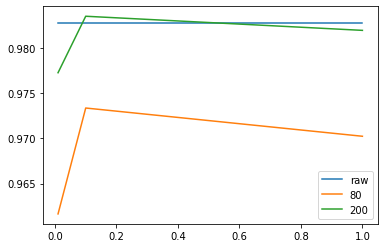

In [23]:
results_df = pd.DataFrame.from_dict(results)
results_df.index = [0.01, 0.1, 1.]
results_df.plot()

# Q5: Neural Networks for Classification

## Prepare the data for CNN input

In [33]:
# Reproductibilites
seed = 42
random.seed(seed)
np.random.seed(seed)
rng = random.Random(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [34]:
class DatasetforCNN(Dataset):
    """Face Label dataset."""

    def __init__(self, X, y, label_dict, transform=None):
        ## TRAINING SET
        # converting training images into torch format
        X /= 255.0
        X = X.astype('float32');
        self.X = X.reshape(X.shape[0], 1, 32, 32)
        # converting the target into torch format
        y = np.array([label_dict[i] for i in y])
        self.y = y.astype(int);
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = {'image': self.X[idx], 'label': np.array([self.y[idx]])}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W

        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}
    

In [35]:
# 26 classes
print(np.unique(y_train))
label_dict = {}
for i, item in enumerate(np.unique(y_train)):
    label_dict[item] = i
print(label_dict)

Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

X_test = np.concatenate([X_test_CMUPIE, X_test_selfies], axis=0)

transform = transforms.Compose([ToTensor()])

trainset = DatasetforCNN(Xtrain, ytrain, label_dict, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

valset = DatasetforCNN(Xval, yval, label_dict, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = DatasetforCNN(X_test, y_test, label_dict, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

dataloaders = {'train': trainloader, 'val': valloader}

[ 0.  2.  3.  4.  6.  7.  9. 13. 14. 15. 28. 29. 32. 33. 35. 36. 38. 39.
 44. 48. 52. 56. 58. 62. 66. 68.]
{0.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 6.0: 4, 7.0: 5, 9.0: 6, 13.0: 7, 14.0: 8, 15.0: 9, 28.0: 10, 29.0: 11, 32.0: 12, 33.0: 13, 35.0: 14, 36.0: 15, 38.0: 16, 39.0: 17, 44.0: 18, 48.0: 19, 52.0: 20, 56.0: 21, 58.0: 22, 62.0: 23, 66.0: 24, 68.0: 25}


## Build CNN model

In [36]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 20, kernel_size=5),
            BatchNorm2d(20),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(20, 50, kernel_size=5),
            BatchNorm2d(50),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            
            Linear(1250, 26),
            ReLU(inplace=True)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# defining the model
model = Net()
# defining the loss function
criterion = nn.CrossEntropyLoss()
# defining the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 28, 28]             520
       BatchNorm2d-2           [-1, 20, 28, 28]              40
              ReLU-3           [-1, 20, 28, 28]               0
         MaxPool2d-4           [-1, 20, 14, 14]               0
            Conv2d-5           [-1, 50, 10, 10]          25,050
       BatchNorm2d-6           [-1, 50, 10, 10]             100
              ReLU-7           [-1, 50, 10, 10]               0
         MaxPool2d-8             [-1, 50, 5, 5]               0
            Linear-9                   [-1, 26]          32,526
             ReLU-10                   [-1, 26]               0
Total params: 58,236
Trainable params: 58,236
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.51
Params size (MB): 0.22
Estimated Tot

## Train the model

In [37]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    history = {'train_acc': [], 'train_loss': [], 'val_acc':[], 'val_loss': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for item in dataloaders[phase]:
                inputs = item['image'].to(device)
                labels = item['label'].squeeze(1).to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double().numpy() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val': 
                history['val_acc'].append(epoch_acc)
                history['val_loss'].append(epoch_loss)
            if phase == 'train':
                history['train_acc'].append(epoch_acc)
                history['train_loss'].append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [38]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.9849 Acc: 0.2237
val Loss: 2.6190 Acc: 0.4284
Epoch 1/24
----------
train Loss: 2.2212 Acc: 0.5838
val Loss: 1.9354 Acc: 0.6689
Epoch 2/24
----------
train Loss: 1.6843 Acc: 0.7206
val Loss: 1.5956 Acc: 0.7181
Epoch 3/24
----------
train Loss: 1.4026 Acc: 0.7628
val Loss: 1.3582 Acc: 0.7506
Epoch 4/24
----------
train Loss: 1.1615 Acc: 0.8060
val Loss: 1.1774 Acc: 0.7998
Epoch 5/24
----------
train Loss: 1.0156 Acc: 0.8209
val Loss: 1.1319 Acc: 0.7942
Epoch 6/24
----------
train Loss: 0.9290 Acc: 0.8262
val Loss: 0.9849 Acc: 0.8043
Epoch 7/24
----------
train Loss: 0.8652 Acc: 0.8301
val Loss: 0.9245 Acc: 0.8143
Epoch 8/24
----------
train Loss: 0.8165 Acc: 0.8325
val Loss: 0.8422 Acc: 0.8143
Epoch 9/24
----------
train Loss: 0.7751 Acc: 0.8353
val Loss: 0.8700 Acc: 0.8143
Epoch 10/24
----------
train Loss: 0.7449 Acc: 0.8363
val Loss: 0.8199 Acc: 0.8177
Epoch 11/24
----------
train Loss: 0.7233 Acc: 0.8373
val Loss: 0.8178 Acc: 0.8221
Epoch 12/24
--

Text(0, 0.5, 'loss')

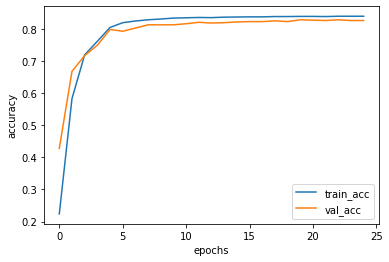

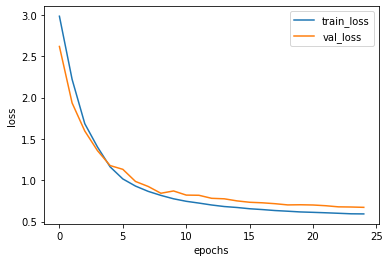

In [39]:
# print learning curves
hist_df = pd.DataFrame.from_dict(hist)

hist_df[['train_acc', 'val_acc']].plot()
plt.xlabel('epochs')
plt.ylabel('accuracy')
hist_df[['train_loss', 'val_loss']].plot()
plt.xlabel('epochs')
plt.ylabel('loss')

## Evaluate the model

In [40]:
alldataloaders = {'train': trainloader, 'val': valloader, 'test': testloader}

for phase, loader in alldataloaders.items():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data["image"], data["label"].squeeze(1)
            outputs = model_ft(inputs)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} images: {:.2f}%'.format(phase, 100 * correct / total))

Accuracy of the network on the train images: 84.11%
Accuracy of the network on the val images: 83.00%
Accuracy of the network on the test images: 80.66%
